In [1]:
"""
Script for medical image analysis using MONAI and PyTorch frameworks.

This script leverages the MONAI framework for healthcare imaging tasks, combined with PyTorch for model training and evaluation. 
The script demonstrates the use of data augmentation, preprocessing, and evaluation metrics for analyzing medical images. 

Authors:
- Md Kamrul Hasan

Date:
- 19-Nov-2024

Dependencies:
- PyTorch
- MONAI
- Additional libraries as listed in the import section

Note:
Ensure all required dependencies are installed before running the script.
"""

# Import essential libraries and modules
from monai.utils import set_determinism, first  # Utilities for reproducibility and data operations
from monai.transforms import (  # Preprocessing and augmentation pipelines
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
)

import monai  # MONAI library for medical image analysis
from monai.data import DataLoader, Dataset, CacheDataset  # Data loading and caching utilities
from monai.config import print_config, USE_COMPILED  # MONAI configuration utilities
from monai.networks.blocks import Warp  # Spatial transformation module for medical image registration
from monai.apps import MedNISTDataset  # Prebuilt medical datasets for quick prototyping

# PyTorch imports for model creation and evaluation
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.autograd import Variable  # Automatic differentiation for operations on tensors
import torch.nn.functional as F  # Commonly used activation functions and loss utilities
import torch.optim as optim  # Optimizers for model training
from torch.utils.data import DataLoader  # Data loading utility for PyTorch

# Libraries for visualization and metric calculation
import torchmetrics  # Metrics for evaluating model performance
import matplotlib.pyplot as plt  # Visualization of results
from torchviz import make_dot, make_dot_from_trace  # Visualize computation graphs
from piqa import SSIM  # Structural Similarity Index Metric for image quality assessment
import visdom  # Visualization library for tracking training progress

# Additional utilities and libraries for data processing
from glob import glob  # File searching and pattern matching
import cv2  # Computer vision operations (e.g., image manipulation)
from scipy.spatial.distance import directed_hausdorff  # Calculate Hausdorff distance
import pandas as pd  # Data analysis and manipulation
import numpy as np  # Numerical operations
import tempfile  # Temporary file creation
import nibabel as nib  # Neuroimaging data I/O
import os  # Operating system interface

from modules.layers import *       # Import custom layers
from utils.helper import *         # Import helper functions
from utils.losses import *         # Import custom loss functions
from modules.FBA_SCA_DLIR import * # Import the FBA-SCA DLIR model implementation

# MONAI-specific loss functions and metrics
from monai.losses import *  # Predefined loss functions for medical image analysis
from monai.metrics import *  # Evaluation metrics for medical imaging tasks

# Custom configuration file
import config  # Configuration file (ensure 'config.py' exists in the same directory)

# Print MONAI configuration and set random seed for reproducibility
print_config()  # Displays MONAI's configuration (e.g., installed version, available features)
set_determinism(42)  # Sets the random seed for reproducible results


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


MONAI version: 1.3.0
Numpy version: 1.26.4
Pytorch version: 2.2.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/miniconda3/envs/phd2/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.12.0
Pillow version: 10.2.0
Tensorboard version: 2.16.2
gdown version: 4.7.3
TorchVision version: 0.17.2
tqdm version: 4.66.2
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.2.1
einops version: 0.7.0
transformers version: 4.21.3
mlflow version: 2.11.3
pynrrd version: 1.0.0
clearml version: 1.15.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
"""
GPU Availability Check and Device Setup

This script checks for the availability of GPUs, sets up the appropriate device (GPU/CPU),
and verifies the configuration to ensure efficient training.
"""

# Print the number of GPUs available
print('How many GPUs = ' + str(torch.cuda.device_count()))

# Device setup: Use GPU if available, otherwise fallback to CPU
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Selected device: {device}")

# Raise an exception if no GPU is available, as CPU training can be significantly slower
if not torch.cuda.is_available():
    raise Exception("GPU not available. CPU training will be too slow.")

# Print the name of the GPU device being used
print("Device name:", torch.cuda.get_device_name(0))


How many GPUs = 2
Selected device: cuda:1
Device name: NVIDIA RTX A6000


In [3]:
from utils.data_loader import NiftiDataset  # Import the custom NiftiDataset class

# Specify the data directory
data_dir = 'Datasets/64/' # Replace with your actual data directory/
print(data_dir) 

# Create a DataLoader for the testing dataset
testData = DataLoader(
    NiftiDataset(
        sorted(glob(data_dir + "image/*fixed.nii")),  # Sorted list of image file paths
        sorted(glob(data_dir + "mask/*fixed.nii")),   # Sorted list of mask file paths
        transform=None  # No transformations applied to the dataset (can be customized)
    ),
    batch_size=1,  # Batch size for testing, defined in the config module
    shuffle=config.shuffle_,  # Whether to shuffle the validation data
    num_workers=config.num_workers  # Number of workers for parallel data loading
)

# Retrieve and print a sample from the testing dataset
test_sample = first(testData)  # Get the first batch from the DataLoader

# Print the shapes of the retrieved sample components
print("Fixed Image Shape:", test_sample['fixed_img'].shape)
print("Fixed Mask Shape:", test_sample['fixed_mask'].shape)
print("Moving Image Shape:", test_sample['moving_img'].shape)
print("Moving Mask Shape:", test_sample['moving_mask'].shape)


Datasets/64/
Fixed Image Shape: torch.Size([1, 1, 64, 64, 64])
Fixed Mask Shape: torch.Size([1, 1, 64, 64, 64])
Moving Image Shape: torch.Size([1, 1, 64, 64, 64])
Moving Mask Shape: torch.Size([1, 1, 64, 64, 64])


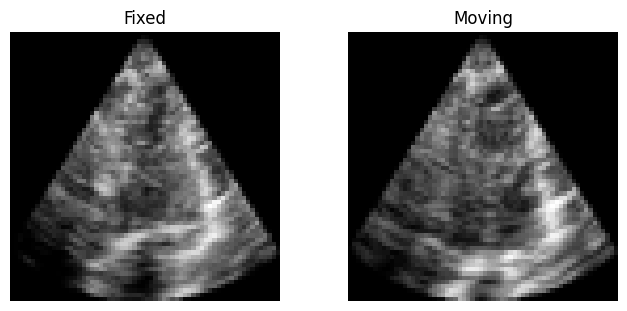

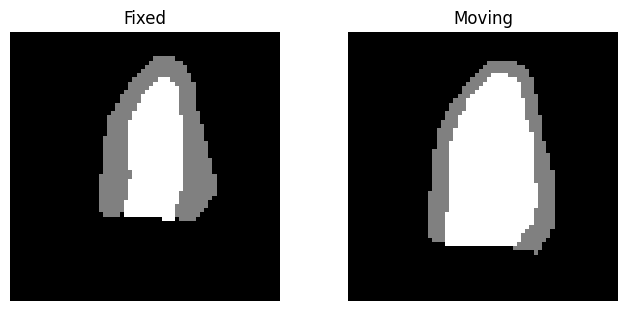

In [4]:
"""
Display Fixed and Moving Images and Masks for Validation

This script visualizes the fixed and moving images as well as their respective masks from a dataset sample. 
The `imshows` function is used to render the images side by side for easy comparison.

"""

# Import the imshows function from the helper module
from utils.helper import imshows

# Visualize the fixed and moving images
imshows(test_sample['fixed_img'], test_sample['moving_img'])

# Visualize the fixed and moving masks
imshows(test_sample['fixed_mask'], test_sample['moving_mask'])


In [5]:
# Initialize evaluation metric
# - `Dice3DMultiClass`: Computes the Dice similarity coefficient for multi-class 3D segmentation.
# - `num_classes`: The number of classes is dynamically set based on the configuration.
dice_multiclass_metric = Dice3DMultiClass(num_classes=config.num_classes)

# Initialize custom loss functions
# - `OptimalTransportLoss`: Implements the optimal transport loss for attention weight alignment.
# - `twinLoss`: Computes a custom twin loss with a regularization factor (0.005 in this case).
# - `NCCLoss`: Local normalized cross-correlation loss, commonly used for image alignment tasks.
# - `MSELoss`: Mean Squared Error loss for regression-based tasks (default PyTorch implementation).
# - `BendingEnergyLoss`: Regularization loss to encourage smooth deformations in image registration.
transport_loss = OptimalTransportLoss()
twin_loss = twinLoss(0.005)
NCC_loss = NCCLoss()
mse_loss = nn.MSELoss()  # Imported from PyTorch's `nn` module
regularization_loss = BendingEnergyLoss()


# Initialize the FBA-SCA DLIR 3D Model
# - `FBA_SCA_DLIR3D`: Feedback Attention and Spatial-Context Alignment-based model for 3D image registration.
# - `device`: The computation device (e.g., 'cuda' for GPU, 'cpu' for CPU) is specified dynamically based on availability.
# - `.to(device)`: Ensures that the model is moved to the specified computation device.

model = FBA_SCA_DLIR3D(device).to(device)

# Initialize the Spatial Transformer module
# - `SpatialTransformer`: Custom layer/module for applying transformations to the input volumes.
# - This is a key component in many medical image registration frameworks, enabling the transformation of moving images to align with fixed images.

spatial_transform = SpatialTransformer().to(device)

# Estimate and print the total number of trainable parameters in the model
# - `estParams`: A utility function that computes the total trainable parameters in the given model.
# - Useful for debugging, understanding model complexity, and benchmarking.

print(f'Total Params = {estParams(model)}')

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403380164/work/aten/src/ATen/native/TensorShape.cpp:3549.)


Total Params = 560478131


In [6]:
# Name for saving the trained model's checkpoint file. 
# This name serves as an identifier for the model architecture, method, or specific experiment.
saveFile = 'FBA_SCA_DLIR'

# Path where the checkpoint of the trained model will be stored.
# The model's parameters will be saved in this file to allow resuming training or inference later.
# The file is saved with a `.pth` extension, commonly used in PyTorch to store model weights.
checkpoint_path = saveFile + '.pth'

# Load the model state from the checkpoint path
# This restores the model weights from a pre-trained model for evaluation
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# Set the model to evaluation mode, which deactivates dropout and batch normalization layers
model.eval()


FBA_SCA_DLIR3D(
  (coattention_encoder): encoder(
    (conv_block1): Sequential(
      (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): GroupNorm(8, 32, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): GroupNorm(16, 64, eps=1e-05, affine=True)
      (5): ReLU(inplace=True)
    )
    (conv_block2): Sequential(
      (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): GroupNorm(16, 64, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): GroupNorm(32, 128, eps=1e-05, affine=True)
      (5): ReLU(inplace=True)
    )
    (conv_block3): Sequential(
      (0): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (2): ReLU(inplace=Tru

In [7]:
"""
This script computes the fraction of non-positive Jacobian determinants (NoP_detJ) for each batch in the validation dataset 
using a deep learning model for medical image registration. 

The script performs the following tasks:
1. Loops through the test dataset (`testData`) and extracts input data (images and masks).
2. Passes the fixed and moving images through the trained model to obtain the predicted displacement field.
3. Calculates the Jacobian determinant of the displacement field using the `jacobian_determinant` function.
4. Computes the fraction of non-positive Jacobian determinants (NoP_detJ) for each batch.
5. Logs the results and saves them to a CSV file.

The results include the names of the test batches and the corresponding NoP_detJ values. The average and standard deviation of the 
NoP_detJ values across all test batches are printed at the end.

Dependencies:
- PyTorch
- NumPy
- pandas

Variables:
- `NoP_detJ_`: List storing the non-positive Jacobian determinant fractions for each test batch.
- `Names`: List storing the names of the test batches.
- `testData`: Validation dataset containing fixed and moving images and their respective masks.
- `model`: The trained deep learning model used for image registration.
- `device`: The device (CPU/GPU) where the computations are performed.
- `saveFile`: The file path to save the results.

Functions:
- `NoP_detJ`: Computes the fraction of non-positive Jacobian determinants for a given displacement field.
- `jacobian_determinant`: Computes the Jacobian determinant of a 3D displacement field by evaluating the spatial derivatives.
"""

# Initialize lists to store results
NoP_detJ_ = []  # List to store the NoP_detJ values for each test batch
Names = []  # List to store the names of each test batch

# Loop through the validation data batches
with torch.no_grad():
    for testBatch_data in testData:

        # Extract input data for the validation batch
        fixed_test_img = testBatch_data['fixed_img'].to(device)
        fixed_test_msk = testBatch_data['fixed_mask'].to(device)
        moving_test_img = testBatch_data['moving_img'].to(device)
        moving_test_msk = testBatch_data['moving_mask'].to(device)

        # Generate displacement field and predict images/masks using the trained model
        outputs = model(fixed_test_img, moving_test_img)

        # Compute the fraction of non-positive Jacobian determinants
        NoP_detJ_.append(NoP_detJ(outputs[0]).item())
        Names.append(testBatch_data['name'][0])  # Store the batch name

    # Print the average and standard deviation of the NoP_detJ values
    print(f"Average test NoP_detJ: {np.mean(NoP_detJ_):.5f} +/- {np.std(NoP_detJ_):.5f}!")


nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.


Average test NoP_detJ: 0.00039 +/- 0.00000!


In [8]:
# Initialize the model and spatial transformer, then load pre-trained weights
# The model is FBA_SCA_DLIR3D, which is a specific model architecture for 3D image registration
# The spatial transformer is used to apply spatial transformations to the images
model = FBA_SCA_DLIR3D(device).to(device)
spatial_transform = SpatialTransformer().to(device)

# Load the model state from the checkpoint path
# This restores the model weights from a pre-trained model for evaluation
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# Set the model to evaluation mode, which deactivates dropout and batch normalization layers
model.eval()

# Initialize lists to store various evaluation metrics across the validation batches
DSC_back, DSC_MYO, DSC_LV, DSC_EPI = [], [], [], []
imageMatrix = []

# Start the evaluation phase without tracking gradients (faster inference)
with torch.no_grad():  # Disables gradient computation during inference for efficiency
    # Iterate over the validation data in batches
    for testBatch_data in testData:
        
        # Extract the input data (images and masks) for the validation batch
        # These are tensors that will be moved to the device (GPU or CPU)
        fixed_test_img = testBatch_data['fixed_img'].to(device)
        fixed_test_msk = testBatch_data['fixed_mask'].to(device)
        moving_test_img = testBatch_data['moving_img'].to(device)
        moving_test_msk = testBatch_data['moving_mask'].to(device)

        # Generate the displacement field and predicted images/masks by passing inputs through the model
        output = model(fixed_test_img, moving_test_img)

        # Apply spatial transformation to the predicted image to align it with the fixed image
        pred_fixed = spatial_transform(moving_test_img, output[0]).to(device)

        # Calculate the Mean Squared Error (MSE) between the predicted image and the fixed image
        loss_raw_img1 = mse_loss(pred_fixed, fixed_test_img)

        # Apply spatial transformation to the predicted mask (the model output for segmentation)
        pred_mask_test = spatial_transform(moving_test_msk, output[0]).to(device)

        # Threshold the predicted mask to convert continuous predictions into binary or categorical values
        pred_mask_test = thresholded(pred_mask_test, config.lower_bound, config.upper_bound)

        # Calculate the Dice Similarity Coefficient (DSC) for the predicted and ground truth masks
        # DSC measures the overlap between the predicted and actual regions of interest (ROI)
        labelDSC_test = dice_multiclass_metric(
            make_one_hot(pred_mask_test, device, C=3),
            make_one_hot(fixed_test_msk, device, C=3)
        )

        # Append the DSC values for each class (background, MYO, LV) to respective lists
        DSC_back.append(labelDSC_test[0].item())
        DSC_MYO.append(labelDSC_test[1].item())
        DSC_LV.append(labelDSC_test[2].item())

        # Store the MSE for the predicted image for later analysis
        imageMatrix.append(loss_raw_img1.item())

        # Post-process the ground truth and predicted masks to balance the classes (e.g., combine MYO and ENDO classes for EPI)
        fixed_test_msk[fixed_test_msk == 0] = 0
        fixed_test_msk[fixed_test_msk == 1] = 1
        fixed_test_msk[fixed_test_msk == 2] = 1
        pred_mask_test[pred_mask_test == 0] = 0
        pred_mask_test[pred_mask_test == 1] = 1
        pred_mask_test[pred_mask_test == 2] = 1

        # Recalculate the DSC for the post-processed masks to ensure consistency after the balancing step
        labelDSC_test = dice_multiclass_metric(
            make_one_hot(pred_mask_test, device, C=3),
            make_one_hot(fixed_test_msk, device, C=3)
        )

        # Append the DSC value for the epi layer (epicardium) to the list
        DSC_EPI.append(labelDSC_test[1].item())

    # After processing all batches, remove duplicate DSC and MSE values
    # This ensures that the values used for metrics are unique and avoids bias from repeated values
    DSC_back = np.unique(DSC_back)
    DSC_MYO = np.unique(DSC_MYO)
    DSC_LV = np.unique(DSC_LV)
    imageMatrix = np.unique(imageMatrix)
    DSC_EPI = np.unique(DSC_EPI)


    # Print the average DSC and MSE for each class (background, MYO, LV, EPI)
    # Displaying both the mean and standard deviation to provide a more complete evaluation
    print(f"Average test DSC Back: {np.mean(DSC_back):.5f} +/- {np.std(DSC_back):.5f}!")
    print(f"Average test DSC MYO: {np.mean(DSC_MYO):.5f} +/- {np.std(DSC_MYO):.5f}!")
    print(f"Average test DSC ENDO: {np.mean(DSC_LV):.5f} +/- {np.std(DSC_LV):.5f}!")
    print(f"Average test DSC EPI: {np.mean(DSC_EPI):.5f} +/- {np.std(DSC_EPI):.5f}!")
    print(f"Average test MSE: {np.mean(imageMatrix):.5f} +/- {np.std(imageMatrix):.5f}!")


Average test DSC Back: 0.99549 +/- 0.00000!
Average test DSC MYO: 0.80912 +/- 0.00000!
Average test DSC ENDO: 0.87751 +/- 0.00000!
Average test DSC EPI: 0.91757 +/- 0.00000!
Average test MSE: 0.00624 +/- 0.00000!


In [9]:
"""
This script processes validation data for medical image registration using a trained deep learning model. 
It generates predictions for the fixed and moving images, computes masks, and saves the results as images in a specified directory.

The script performs the following tasks:
1. Checks if the specified save directory (`saveFile`) exists, and creates it if not.
2. Loops through the batches in the validation dataset (`testData`).
3. For each batch, extracts the fixed and moving images, as well as their corresponding masks.
4. Reshapes the images and masks into 3D arrays (configurable size).
5. Passes the images through the trained model to generate the displacement field and predicted images/masks.
6. Applies spatial transformations to get the predicted fixed images and masks.
7. Thresholds the predicted mask values and processes them for further analysis.
8. Saves the processed images (fixed, moving, predicted images, and masks) as PNG files in the specified save directory.
9. Outputs the name of the batch currently being processed.

Dependencies:
- PyTorch
- NumPy
- OpenCV (cv2)

Variables:
- `saveFile`: Path to the directory where results will be saved.
- `testData`: Dataset containing validation batches of fixed and moving images and their corresponding masks.
- `device`: Device (CPU/GPU) used for computations.
- `model`: The trained deep learning model used for image registration.
- `outputs`: Output from the model (displacement field and predicted images/masks).
- `fixed_test_img`, `moving_test_img`: Fixed and moving images from the validation batch.
- `fixed_test_msk`, `moving_test_msk`: Corresponding masks for the fixed and moving images.
- `pred_disp`: The predicted displacement field generated by the model.
- `pred_mask_test`: The predicted mask for the moving image, post thresholding.
- `pred_img`, `pred_mask_LV_MYO`, `pred_mask_EPI`: Predicted images and masks in the 3D volume.
- `fixed_msk_LV_MYO`, `moving_msk_LV_MYO`, `fixed_msk_EPI`, `moving_msk_EPI`: Masks reshaped and processed from the fixed and moving images.

File Saving:
- For each slice in the 3D volumes (along the z-axis), the script saves images for:
  1. Fixed, moving, and predicted images
  2. Fixed, moving, and predicted masks for different anatomical regions (e.g., LV_MYO, EPI)
- The images are saved in the specified `saveFile` directory, with filenames including the batch name and slice index.

The script is intended to visualize and save 3D images and masks for further evaluation or analysis.

Note:
- The script assumes that the images and masks are 3D volumes (with dimensions matching `config.img_size`).
- The `thresholded` function is assumed to be used to binarize the mask values based on specified thresholds (`config.lower_bound` and `config.upper_bound`).
- For debugging purposes, there are commented-out print statements and plotting functions (`PLOTs`).
"""

# Check if saveFile directory exists, if not, create it
if not os.path.exists(saveFile):
    os.makedirs(saveFile)

# Loop through the validation data batches
with torch.no_grad():
    for testBatch_data in testData:

        # Extract input data for the validation batch
        fixed_test_img = testBatch_data['fixed_img'].to(device)
        fixed_test_msk = testBatch_data['fixed_mask'].to(device)
        moving_test_img = testBatch_data['moving_img'].to(device)
        moving_test_msk = testBatch_data['moving_mask'].to(device)

        # Reshape and detach the masks and images from the GPU
        fixed_msk_LV_MYO = (fixed_test_msk[0][0]).reshape(config.img_size, config.img_size, config.img_size).detach().cpu().numpy()
        moving_msk_LV_MYO = (moving_test_msk[0][0]).reshape(config.img_size, config.img_size, config.img_size).detach().cpu().numpy()
        fixed_img = (fixed_test_img[0][0]).reshape(config.img_size, config.img_size, config.img_size).detach().cpu().numpy()
        moving_img = (moving_test_img[0][0]).reshape(config.img_size, config.img_size, config.img_size).detach().cpu().numpy()

        # Generate displacement field and predicted images/masks using the model
        outputs = model(fixed_test_img, moving_test_img)

        # Apply spatial transformation to get predicted images
        pred_fixed = spatial_transform(moving_test_img, outputs[0]).to(device)
        pred_img = (pred_fixed[0][0]).reshape(config.img_size, config.img_size, config.img_size).detach().cpu().numpy()

        # Threshold and process the predicted mask
        pred_mask_test = spatial_transform(moving_test_msk, outputs[0]).to(device)
        pred_mask_test = thresholded(pred_mask_test, config.lower_bound, config.upper_bound)
        pred_msk_LV_MYO = (pred_mask_test[0][0]).reshape(config.img_size, config.img_size, config.img_size).detach().cpu().numpy()

        # Adjust masks for output consistency (binary regions for LV_MYO and EPI)
        fixed_test_msk[fixed_test_msk == 0] = 0
        fixed_test_msk[fixed_test_msk == 1] = 1
        fixed_test_msk[fixed_test_msk == 2] = 1

        pred_mask_test[pred_mask_test == 0] = 0
        pred_mask_test[pred_mask_test == 1] = 1
        pred_mask_test[pred_mask_test == 2] = 1

        moving_test_msk[moving_test_msk == 0] = 0
        moving_test_msk[moving_test_msk == 1] = 1
        moving_test_msk[moving_test_msk == 2] = 1

        # Process masks for EPI (epicardial) and LV_MYO (left ventricular myocardium)
        fixed_msk_EPI = (fixed_test_msk[0][0]).reshape(config.img_size, config.img_size, config.img_size).detach().cpu().numpy()
        pred_msk_EPI = (pred_mask_test[0][0]).reshape(config.img_size, config.img_size, config.img_size).detach().cpu().numpy()
        moving_msk_EPI = (moving_test_msk[0][0]).reshape(config.img_size, config.img_size, config.img_size).detach().cpu().numpy()

        # Print the name of the test batch currently being processed
        print(testBatch_data['name'][0])

        # Save the processed images and masks for each slice in the 3D volume
        for s in range(config.img_size):
            cv2.imwrite(saveFile + '/' + testBatch_data['name'][0] + '_fixed_msk_LV_MYO_' + '{:03d}'.format(s) + '.png',
                        100 * fixed_msk_LV_MYO[:, :, s])
            cv2.imwrite(saveFile + '/' + testBatch_data['name'][0] + '_fixed_msk_EPI_' + '{:03d}'.format(s) + '.png',
                        100 * fixed_msk_EPI[:, :, s])

            cv2.imwrite(saveFile + '/' + testBatch_data['name'][0] + '_pred_msk_LV_MYO_' + '{:03d}'.format(s) + '.png',
                        100 * pred_msk_LV_MYO[:, :, s])
            cv2.imwrite(saveFile + '/' + testBatch_data['name'][0] + '_pred_msk_EPI_' + '{:03d}'.format(s) + '.png',
                        100 * pred_msk_EPI[:, :, s])

            cv2.imwrite(saveFile + '/' + testBatch_data['name'][0] + '_moving_msk_LV_MYO_' + '{:03d}'.format(s) + '.png',
                        100 * moving_msk_LV_MYO[:, :, s])
            cv2.imwrite(saveFile + '/' + testBatch_data['name'][0] + '_moving_msk_EPI_' + '{:03d}'.format(s) + '.png',
                        100 * moving_msk_EPI[:, :, s])

            cv2.imwrite(saveFile + '/' + testBatch_data['name'][0] + '_fixed_img_' + '{:03d}'.format(s) + '.png',
                        255 * fixed_img[:, :, s])
            cv2.imwrite(saveFile + '/' + testBatch_data['name'][0] + '_moving_img_' + '{:03d}'.format(s) + '.png',
                        255 * moving_img[:, :, s])
            cv2.imwrite(saveFile + '/' + testBatch_data['name'][0] + '_pred_img_' + '{:03d}'.format(s) + '.png',
                        255 * pred_img[:, :, s])


MITEA_034_scan2_
